In [292]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [293]:
import numpy as np
import pandas as pd
import datetime as dt

from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [294]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [295]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [296]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [297]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [298]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [299]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [300]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# OR most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

'2017-08-23'

In [301]:
# Convert date to datetime for reference
most_recent_date_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')

Date: 2016-08-24, Precipitation: 0.08
Date: 2016-08-25, Precipitation: 0.08
Date: 2016-08-26, Precipitation: 0.0
Date: 2016-08-27, Precipitation: 0.0
Date: 2016-08-28, Precipitation: 0.01
Date: 2016-08-29, Precipitation: 0.0
Date: 2016-08-30, Precipitation: 0.0
Date: 2016-08-31, Precipitation: 0.13
Date: 2016-09-01, Precipitation: 0.0
Date: 2016-09-02, Precipitation: 0.0
Date: 2016-09-03, Precipitation: 0.0
Date: 2016-09-04, Precipitation: 0.03
Date: 2016-09-05, Precipitation: None
Date: 2016-09-06, Precipitation: None
Date: 2016-09-07, Precipitation: 0.05
Date: 2016-09-08, Precipitation: 0.0
Date: 2016-09-09, Precipitation: 0.03
Date: 2016-09-10, Precipitation: 0.0
Date: 2016-09-11, Precipitation: 0.05
Date: 2016-09-12, Precipitation: 0.0
Date: 2016-09-13, Precipitation: 0.02
Date: 2016-09-14, Precipitation: 1.32
Date: 2016-09-15, Precipitation: 0.42
Date: 2016-09-16, Precipitation: 0.06
Date: 2016-09-17, Precipitation: 0.05
Date: 2016-09-18, Precipitation: 0.0
Date: 2016-09-19, Preci

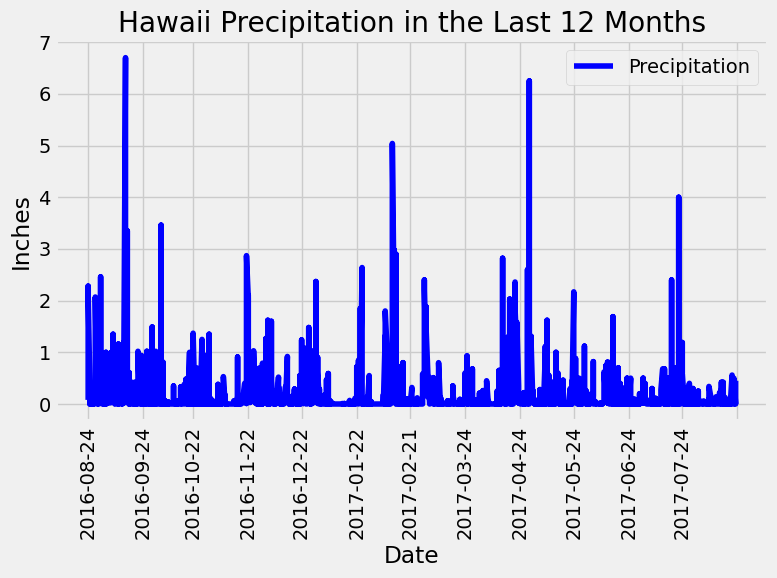

In [302]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year ago
query_date = most_recent_date_dt - timedelta(days=365)

last_12_months_precipitation = session.query(
    Measurement.station, 
    Measurement.date, 
    Measurement.prcp, 
    Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date.desc()).all()

# Perform a query to retrieve the data and precipitation scores
last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

for row in last_12_months_prcp:
    print(f"Date: {row.date}, Precipitation: {row.prcp}")

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months_prcp, columns=['Date', 'Precipitation'])

# Remove null values
df_clean = df.dropna(subset=['Precipitation'])

# Sort the dataframe by date
df_sorted = df_clean.sort_values(by = 'Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))
plt.plot(df_sorted['Date'], df_sorted['Precipitation'], color='b', label = 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Hawaii Precipitation in the Last 12 Months')
plt.legend()
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

# Show only a certain number of x-value ticks
#plt.gca().xaxis.set_major_locator(MaxNLocator(9))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [303]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = df_sorted.describe()
display(precipitation_summary)

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [304]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).distinct().count()
station_count

9

In [305]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station,
    func.count()
).group_by(
    Measurement.station
).order_by(
    func.count().desc()
).all()

for station, count in active_stations:
    print(f"Station: {station}, Row Count: {count}")

# Print the most active station
most_active_id = None
if active_stations:
    most_active_station = active_stations[0] 
    station, count = most_active_station
    most_active_id = station
    print()
    print(f"Most Active Station: {station}, Row Count: {count}")
else:
    print("No data found")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511

Most Active Station: USC00519281, Row Count: 2772


In [306]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.round(func.avg(Measurement.tobs),2)
).filter(
    Measurement.station == most_active_id
).all()

for lowest, highest, avg in temp_stats:
    print(f"Lowest Temperature: {lowest}F, Highest Temperature: {highest}F, Average Temperature: {avg}F")

Lowest Temperature: 54.0F, Highest Temperature: 85.0F, Average Temperature: 71.66F


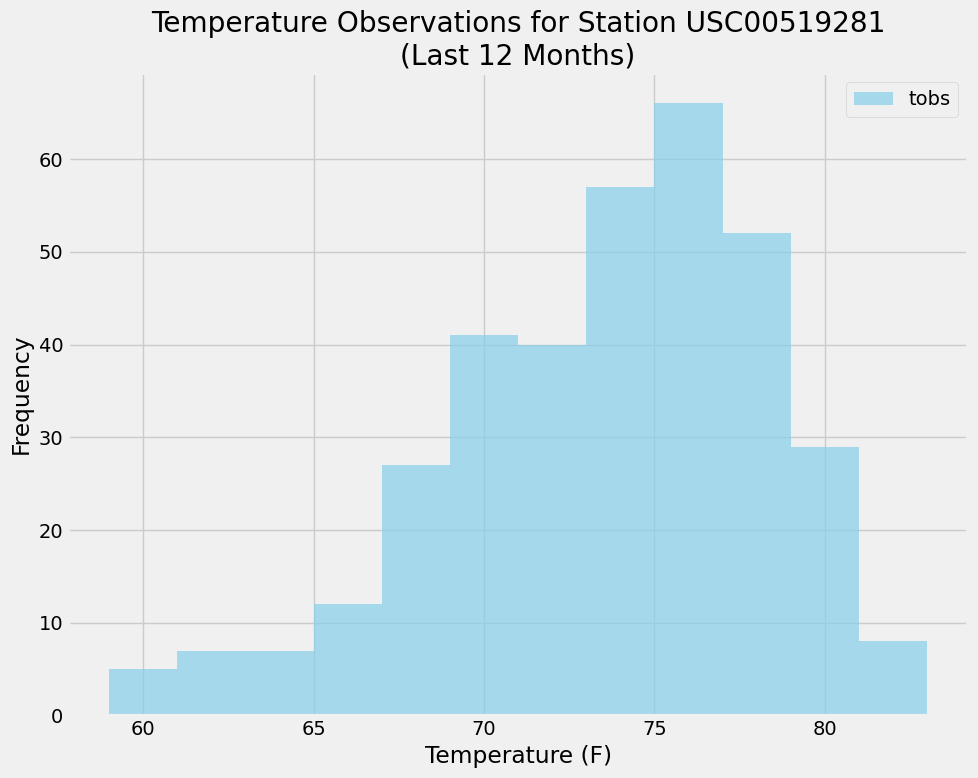

In [307]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months_temp = session.query(
    Measurement.tobs
).filter(
    Measurement.station == most_active_id
).filter(
    Measurement.date >= query_date
).all()

temperatures = [temp[0] for temp in last_12_months_temp]

# Create histogram
plt.figure(figsize=(10, 8))
plt.hist(temperatures, bins=12, alpha=0.7, color='skyblue', label='tobs')
plt.title(f'Temperature Observations for Station {most_active_id}\n(Last 12 Months)')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [308]:
# Close Session
session.close()